# imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.discrete.count_model as smdc

https://www.statsmodels.org/stable/large_data.html#divide-and-conquer-distributing-jobs

In [3]:
import pyarrow.parquet as pq

class DataSet(dict):
    def __init__(self, path):
        self.parquet = pq.ParquetFile(path)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

In [4]:
import pyarrow as pa

In [5]:
# set some formatting preferences to make things nicer to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# load in and summarize

Count data from scMPRA performmed by Shendure lab, downloaded from GEO: GSE217686

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217686

In [6]:
counts = pd.read_table('../../../data/GSE217686_assigned_oBC_CRE_mBC_joined_counts_sc_rep_mEB_series.txt')

In [7]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


- cellBC: cell barcode, 1 per cell no repeats
- rep_id: are these biological or technical replicates? Biological, but kinda both
- oBC: Tornado barcodes, circular RNA barcodes to indicate successful transfection of a given CRE into a given cell
- mBC: mRNA barcode for quantifying CRE activity 
- CRE_class: type of cis-regulatory element
- CRE_id: CRE identifier
- reads_oBC: 
- UMIs_oBC: 
- reads_mBC:
- UMIs_mBC: 

Questions/Notes to discuss with Mackenzie:
- bio vs tech reps?
- can a CRE-cell combo have more than one oBC-mBC pair? 
- can we just talk through which things can be used multiple times, which have more unique values than they are tagging and which combinations we're looking for? I think I have it all straight in my head but would be good to go through it with someone more familiar with the experimental side of things. 
- UMIs vs reads for these barcodes, the difference here is not clear to me. 
- by endogenous do they mean without inserted CREs in this case? 
- In some of Rohit's code I'm getting the sense that he's modeling the number of cells captured of each cell type is that the goal here?
- okay nevermind, I think cell type is a covariate for modeling counts per oBC 
- I can't track down this file where he got the cell type mappings from, any idea where that come from? 

In [8]:
counts.describe()

,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
count,877064.000,877064.000,877064.000,877064.000
mean,168.055,146.082,108.523,5.708
std,169.740,140.720,843.699,43.481
min,11.000,11.000,0.000,0.000
25%,61.000,55.000,0.000,0.000
50%,119.000,107.000,0.000,0.000
75%,217.000,190.000,0.000,0.000
max,5876.000,4616.000,60250.000,2890.000


In [9]:
counts.dtypes

cellBC       object
rep_id       object
oBC          object
mBC          object
CRE_class    object
CRE_id       object
reads_oBC     int64
UMIs_oBC      int64
reads_mBC     int64
UMIs_mBC      int64
dtype: object

In [10]:
counts.nunique()

cellBC       43447
rep_id           6
oBC          28938
mBC          28938
CRE_class        2
CRE_id         212
reads_oBC     2040
UMIs_oBC      1732
reads_mBC     8591
UMIs_mBC      1045
dtype: int64

In [11]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


- look into modeling/stats packages
- 

(1.0, 3034.4500000000003)

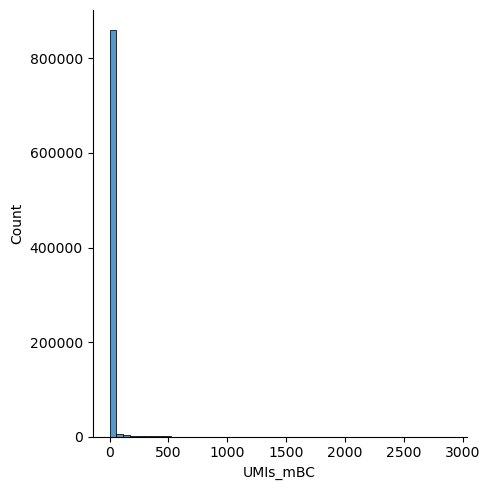

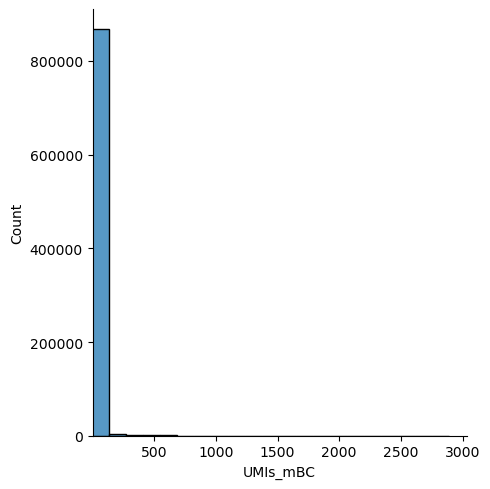

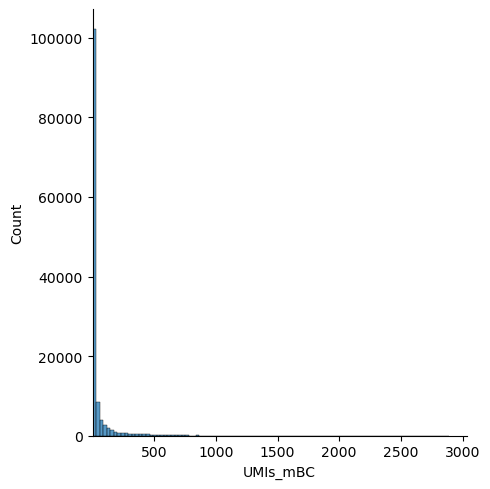

In [12]:
sns.displot(counts['UMIs_mBC'], bins = 50)

sns.displot(counts['UMIs_mBC'])
plt.xlim(1,)
sns.displot(counts['UMIs_mBC'][counts['UMIs_mBC']!=0], bins=100)
plt.xlim(1)

# Model choices

## statsmodels

GLMs: https://www.statsmodels.org/stable/glm.html

Regression with discrete dependent variable (includes zero-inflated models): https://www.statsmodels.org/stable/discretemod.html

To use this we'll probably want our scMPRA data class to have outcome/predictor attributes that can nicely go into this modeling framework (they call is endog/exog but that will just get confusing in this context). And maybe a way for the user to define what all they would like to be included in the predictor set. 

Patsy for making more complex design matrices: https://patsy.readthedocs.io/en/latest/formulas.html

In [13]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


In [14]:
cell_type_mapping = pd.read_table('../../../data/meb_cbc_to_cell_type_mapping.txt')

In [15]:
cell_type_mapping

,orig.ident,nCount_RNA,nFeature_RNA,percent_mt,seurat_clusters,annotation
A1_AAACCCAAGATGGGCT-1,repA1,890,540,6.292,1,Neuroectoderm (brain)
A1_AAACCCAAGGATTTGA-1,repA1,2311,1245,4.457,4,Ex. Endoderm (parietal)
A1_AAACCCAGTGCCTAAT-1,repA1,4180,1766,2.608,2,Mesoderm
A1_AAACCCAGTGTTAGCT-1,repA1,4597,2100,5.895,1,Neuroectoderm (brain)
A1_AAACCCAGTTCCGCTT-1,repA1,3747,1893,5.311,1,Neuroectoderm (brain)
...,...,...,...,...,...,...
2B2_TTTGTTGGTGCATTTG-1,rep2B2,4190,1822,2.840,5,Epiblast/primitive streak
2B2_TTTGTTGGTTCGGTTA-1,rep2B2,746,543,7.641,7,Neuroectoderm (rostral)
2B2_TTTGTTGTCAGGACAG-1,rep2B2,1961,1058,6.833,3,Surface Ectoderm
2B2_TTTGTTGTCCCTCAAC-1,rep2B2,814,539,5.897,3,Surface Ectoderm


In [16]:
counts['cell_type_annotation'] = np.array(cell_type_mapping.loc[counts['cellBC']]['annotation'])

In [17]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC,cell_type_annotation
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0,Surface Ectoderm
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0,Surface Ectoderm
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0,Surface Ectoderm
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0,Surface Ectoderm
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0,Surface Ectoderm
...,...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0,Neuroectoderm (rostral)
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11,Neuroectoderm (rostral)
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0,Mesoderm
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0,Mesoderm


In [18]:
x_vars = counts[['cell_type_annotation','rep_id','CRE_class','CRE_id']]
y_vars = counts['UMIs_mBC']
simple_formula = "UMIs_mBC ~ C(cell_type_annotation) + C(rep_id) + C(CRE_class) + C(CRE_id)"

In [19]:
counts_groupby_cre = counts.groupby(by=['cellBC','rep_id','CRE_class','CRE_id','cell_type_annotation']).sum().reset_index()
counts_groupby_cre.shape

(778248, 11)

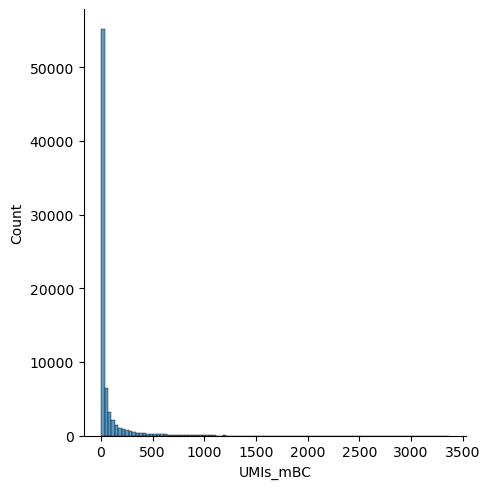

In [20]:
sns.displot(counts_groupby_cre[counts_groupby_cre.UMIs_mBC>1]['UMIs_mBC'], bins=100)

# 'Big Data' efficiency 
Looking into using parquet format to speed up model fitting as suggested by statsmodels docs

https://www.statsmodels.org/stable/large_data.html

https://fastparquet.readthedocs.io/en/latest/

In [21]:

table = pa.Table.from_pandas(counts)
pq.write_table(table, '../../../data/shendure_mpra_counts_GSE217686.parq')
counts_parq = DataSet('../../../data/shendure_mpra_counts_GSE217686.parq')


table = pa.Table.from_pandas(counts_groupby_cre)
pq.write_table(table, '../../../data/shendure_mpra_counts_grouped_GSE217686.parq')
counts_parq_grouped = DataSet('../../../data/shendure_mpra_counts_grouped_GSE217686.parq')

In [22]:
# takes ~11 minutes at maxiter=35
# maxiter=100, 14 minutes
# maxiter=500, successful optimization at 197 iterations, 18 minutes
#mod_nbin_parq = smf.negativebinomial(formula = simple_formula, data = counts_parq).fit(maxiter=35)
#mod_nbin_parq = smf.negativebinomial(formula = simple_formula, data = counts_parq).fit(maxiter=1000)

In [23]:
counts_model = smf.negativebinomial(formula = simple_formula, data = counts_parq)

In [24]:
counts_model_discrete = smdc.NegativeBinomialP.from_formula(formula = simple_formula, data = counts_parq)

In [25]:
counts_grouped_model = smf.negativebinomial(formula = simple_formula, data = counts_parq_grouped)

In [26]:
counts_model_fit = counts_model.fit()

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.735571
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
counts_model_discrete_fit = counts_model_discrete.fit()

In [ ]:
counts_model_discrete_regfit = counts_model_discrete.fit_regularized()

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7350069301833488
            Iterations: 298
            Function evaluations: 300
            Gradient evaluations: 298


In [ ]:
counts_model_discrete_regfit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: NegativeBinomialP
==============================================================================================================
Model:                            NegativeBinomialP               Method:                         MLE         
Dependent Variable:               UMIs_mBC                        Pseudo R-squared:               0.233       
Date:                             2024-09-27 09:58                AIC:                            1289752.2364
No. Observations:                 877064                          BIC:                            1292416.2649
Df Model:                         226                             Log-Likelihood:                 -6.4465e+05 
Df Residuals:                     876837                          LL-Null:                        -8.4004e+05 
Converged:                        1.0000                          LLR p-value:                    0.0000      
No. Iterations:                   298.0000                        Scale:                          1.0000      
--------------------------------------------------------------------------------------------------------------
                                                      Coef.   Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------------------------------------------
Intercept                                            -3.9923     0.1287 -31.0088 0.0000     -4.2447    -3.7400
C(cell_type_annotation)[T.Epiblast/primitive streak]  0.5995     0.0315  19.0180 0.0000      0.5378     0.6613
C(cell_type_annotation)[T.Ex. Endoderm (parietal)]    1.0103     0.0317  31.9009 0.0000      0.9483     1.0724
C(cell_type_annotation)[T.Ex. Endoderm (visceral)]   -0.0192     0.0327  -0.5876 0.5568     -0.0834     0.0449
C(cell_type_annotation)[T.Haematoendothelial]         0.0421     0.0365   1.1536 0.2487     -0.0294     0.1136
C(cell_type_annotation)[T.Mesoderm]                  -0.5130     0.0312 -16.4194 0.0000     -0.5743    -0.4518
C(cell_type_annotation)[T.Neuroectoderm (brain)]     -0.4435     0.0311 -14.2692 0.0000     -0.5044    -0.3826
C(cell_type_annotation)[T.Neuroectoderm (rostral)]   -0.4935     0.0368 -13.3942 0.0000     -0.5657    -0.4213
C(cell_type_annotation)[T.Pluripotent]                0.8496     0.0304  27.9340 0.0000      0.7900     0.9093
C(cell_type_annotation)[T.Surface Ectoderm]          -0.7780     0.0322 -24.1854 0.0000     -0.8410    -0.7149
C(rep_id)[T.2B2]                                     -0.0599     0.0111  -5.4037 0.0000     -0.0817    -0.0382
C(rep_id)[T.A1]                                      -0.0796     0.0138  -5.7758 0.0000     -0.1066    -0.0526
C(rep_id)[T.A2]                                      -0.0739     0.0133  -5.5506 0.0000     -0.1000    -0.0478
C(rep_id)[T.B1]                                      -0.0138     0.0125  -1.1057 0.2688     -0.0382     0.0106
C(rep_id)[T.B2]                                       0.0236     0.0124   1.9056 0.0567     -0.0007     0.0478
C(CRE_class)[T.promoters]                             3.9563 20238.0288   0.0002 0.9998 -39661.8512 39669.7638
C(CRE_id)[T.Bend5_chr4_8170]                          0.6959     0.1625   4.2813 0.0000      0.3773     1.0145
C(CRE_id)[T.Bend5_chr4_8172]                         -0.3490     0.2142  -1.6295 0.1032     -0.7687     0.0708
C(CRE_id)[T.Bend5_chr4_8174]                          1.3884     0.1337  10.3858 0.0000      1.1264     1.6505
C(CRE_id)[T.Bend5_chr4_8175]                          3.7898     0.1296  29.2317 0.0000      3.5357     4.0439
C(CRE_id)[T.Bend5_chr4_8179]                          1.8226     0.1432  12.7282 0.0000      1.5419     2.1032
C(CRE_id)[T.Bend5_chr4_8192]                         -0.7531     0.1893  -3.9791 0.0001     -1.1241    -0.3822
C(CRE_id)[T.Bend5_chr4_8199]                          0.4162     0.1465   2.8415 0.0045      0.1291     0.70

In [ ]:
counts_grouped_model_fit = counts_grouped_model.fit()

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.791522
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
counts_model_fit.summary2()

NameError: name 'counts_model_fit' is not defined

In [ ]:
counts_model_discrete_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: NegativeBinomialP
================================================================================================================
Model:                              NegativeBinomialP               Pseudo R-squared:               0.232       
Dependent Variable:                 UMIs_mBC                        AIC:                            1290834.1083
Date:                               2024-09-27 10:05                BIC:                            1293486.4524
No. Observations:                   877064                          Log-Likelihood:                 -6.4519e+05 
Df Model:                           225                             LL-Null:                        -8.4004e+05 
Df Residuals:                       876838                          LLR p-value:                    0.0000      
Converged:                          0.0000                          Scale:                          1.0000      
Method:                             MLE                                                                         
----------------------------------------------------------------------------------------------------------------
                                                       Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
----------------------------------------------------------------------------------------------------------------
Intercept                                              -3.9778     0.1376 -28.9142 0.0000     -4.2474    -3.7081
C(cell_type_annotation)[T.Epiblast/primitive streak]    0.4947     0.0323  15.3253 0.0000      0.4315     0.5580
C(cell_type_annotation)[T.Ex. Endoderm (parietal)]      0.8190     0.0324  25.3106 0.0000      0.7556     0.8824
C(cell_type_annotation)[T.Ex. Endoderm (visceral)]     -0.2898     0.0334  -8.6822 0.0000     -0.3552    -0.2244
C(cell_type_annotation)[T.Haematoendothelial]          -0.2748     0.0369  -7.4408 0.0000     -0.3472    -0.2024
C(cell_type_annotation)[T.Mesoderm]                    -0.6033     0.0320 -18.8411 0.0000     -0.6660    -0.5405
C(cell_type_annotation)[T.Neuroectoderm (brain)]       -0.5426     0.0319 -17.0303 0.0000     -0.6051    -0.4802
C(cell_type_annotation)[T.Neuroectoderm (rostral)]     -0.4682     0.0376 -12.4383 0.0000     -0.5419    -0.3944
C(cell_type_annotation)[T.Pluripotent]                  0.7067     0.0311  22.6930 0.0000      0.6456     0.7677
C(cell_type_annotation)[T.Surface Ectoderm]            -0.9894     0.0329 -30.0792 0.0000     -1.0538    -0.9249
C(rep_id)[T.2B2]                                       -0.1233     0.0112 -11.0217 0.0000     -0.1452    -0.1013
C(rep_id)[T.A1]                                        -0.0983     0.0139  -7.0515 0.0000     -0.1257    -0.0710
C(rep_id)[T.A2]                                        -0.0783     0.0135  -5.8069 0.0000     -0.1047    -0.0519
C(rep_id)[T.B1]                                        -0.0687     0.0126  -5.4729 0.0000     -0.0933    -0.0441
C(rep_id)[T.B2]                                        -0.0409     0.0125  -3.2851 0.0010     -0.0653    -0.0165
C(CRE_class)[T.promoters]                            -813.5413 11034.6886  -0.0737 0.9412 -22441.1335 20814.0509
C(CRE_id)[T.Bend5_chr4_8170]                            0.7977     0.1707   4.6738 0.0000      0.4632     1.1321
C(CRE_id)[T.Bend5_chr4_8172]                           -0.2965     0.2268  -1.3073 0.1911     -0.7411     0.1480
C(CRE_id)[T.Bend5_chr4_8174]                            1.6003     0.1420  11.2725 0.0000      1.3221     1.8786
C(CRE_id)[T.Bend5_chr4_8175]                            3.8735     0.1381  28.0402 0.0000      3.6027     4.1442
C(CRE_id)[T.Bend5_chr4_8179]                            2.0695     0.1508  13.7210 0.0000      1.7739     2.3651
C(CRE_id)[T.Bend5_chr4_8192]                           -0.5884     0.1959  -3.0037 0.0027     -0.9723    -0.2044
C(CRE_id)[T.Bend5_chr4_8199]           

In [ ]:
model_zinb = smdc.ZeroInflatedNegativeBinomialP.from_formula(formula = simple_formula, data = counts_parq, missing='raise')

In [ ]:
model_zinb.exog_names

['inflate_const',
 'Intercept',
 'C(cell_type_annotation)[T.Epiblast/primitive streak]',
 'C(cell_type_annotation)[T.Ex. Endoderm (parietal)]',
 'C(cell_type_annotation)[T.Ex. Endoderm (visceral)]',
 'C(cell_type_annotation)[T.Haematoendothelial]',
 'C(cell_type_annotation)[T.Mesoderm]',
 'C(cell_type_annotation)[T.Neuroectoderm (brain)]',
 'C(cell_type_annotation)[T.Neuroectoderm (rostral)]',
 'C(cell_type_annotation)[T.Pluripotent]',
 'C(cell_type_annotation)[T.Surface Ectoderm]',
 'C(rep_id)[T.2B2]',
 'C(rep_id)[T.A1]',
 'C(rep_id)[T.A2]',
 'C(rep_id)[T.B1]',
 'C(rep_id)[T.B2]',
 'C(CRE_class)[T.promoters]',
 'C(CRE_id)[T.Bend5_chr4_8170]',
 'C(CRE_id)[T.Bend5_chr4_8172]',
 'C(CRE_id)[T.Bend5_chr4_8174]',
 'C(CRE_id)[T.Bend5_chr4_8175]',
 'C(CRE_id)[T.Bend5_chr4_8179]',
 'C(CRE_id)[T.Bend5_chr4_8192]',
 'C(CRE_id)[T.Bend5_chr4_8199]',
 'C(CRE_id)[T.Bend5_chr4_8201]',
 'C(CRE_id)[T.Btg1_chr10_9572]',
 'C(CRE_id)[T.Btg1_chr10_9578]',
 'C(CRE_id)[T.Btg1_chr10_9588]',
 'C(CRE_id)[T.Btg1

In [ ]:
fit_zinb = model_zinb.fit_regularized(maxiter=1000)

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
fit_zinb.summary()

NameError: name 'fit_zinb' is not defined

In [ ]:
print(model_zinb)

# things to try
- sum counts for multiple barcodes of the same CRE
- testing suite
    - likelihood, how good are the models
    - how good is good enough?

-statlect book